In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dates = pd.read_csv('data/dates.csv', header=None, names=['Ano', 'Mes', 'Dia'])
dates.head()

,Ano,Mes,Dia
0,1931,1,1
1,1931,1,2
2,1931,1,3
3,1931,1,4
4,1931,1,5


In [3]:
# Cria uma coluna de data completa, especificando explicitamente o formato
dates['Data'] = pd.to_datetime(dates[['Ano', 'Mes', 'Dia']].astype(str).agg('-'.join, axis=1), format='%Y-%m-%d')
dates.head()

,Ano,Mes,Dia,Data
0,1931,1,1,1931-01-01
1,1931,1,2,1931-01-02
2,1931,1,3,1931-01-03
3,1931,1,4,1931-01-04
4,1931,1,5,1931-01-05


In [4]:
metadata = pd.read_csv('data/metadata_latinamerica.csv', header=None, names=['Latitude', 'Longitude', 'Elevacao'])
metadata.head()

,Latitude,Longitude,Elevacao
0,32.433,-99.850,545.3
1,24.583,-81.683,1.8
2,25.788,-80.317,1.4
3,25.483,-80.383,1.5
4,25.650,-80.433,2.0


In [5]:
tw = pd.read_csv('data/tw_latinamerica.csv', header=None)
tw.head()

,0,1,2,3,4,5,6,7,8,9,...,396,397,398,399,400,401,402,403,404,405
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
# Passo 1: Mesclar as datas com os dados de temperatura
# Primeiro, resetamos o índice de 'dates' para usar como chave de junção
dates_reset = dates.reset_index(drop=True)
dates_reset.head()

,Ano,Mes,Dia,Data
0,1931,1,1,1931-01-01
1,1931,1,2,1931-01-02
2,1931,1,3,1931-01-03
3,1931,1,4,1931-01-04
4,1931,1,5,1931-01-05


In [7]:
# Criamos um DataFrame longo a partir de 'tw'
tw_long = tw.melt(var_name='Estacao', value_name='Temperatura', ignore_index=False)
tw_long = tw_long.reset_index().rename(columns={'index': 'date_index'})
tw_long.head()

,date_index,Estacao,Temperatura
0,0,0,NaN
1,1,0,NaN
2,2,0,NaN
3,3,0,NaN
4,4,0,NaN


In [8]:
# Mesclamos com as datas
merged_data = pd.merge(dates_reset, tw_long, left_index=True, right_on='date_index')

In [9]:
merged_data.head()

,Ano,Mes,Dia,Data,date_index,Estacao,Temperatura
0,1931,1,1,1931-01-01,0,0,NaN
33968,1931,1,1,1931-01-01,0,1,NaN
67936,1931,1,1,1931-01-01,0,2,NaN
101904,1931,1,1,1931-01-01,0,3,NaN
135872,1931,1,1,1931-01-01,0,4,NaN


In [10]:
# Passo 2: Adicionar informações de metadata
# Primeiro, garantimos que os nomes das estações em 'metadata' correspondam aos em 'tw'
metadata_reset = metadata.reset_index().rename(columns={'index': 'Estacao'})
metadata_reset.head()

,Estacao,Latitude,Longitude,Elevacao
0,0,32.433,-99.850,545.3
1,1,24.583,-81.683,1.8
2,2,25.788,-80.317,1.4
3,3,25.483,-80.383,1.5
4,4,25.650,-80.433,2.0


In [11]:
# Agora mesclamos com as informações de metadata
final_data = pd.merge(merged_data, metadata_reset, on='Estacao')

In [12]:
# Passo 3: Limpeza e organização final
final_data = final_data.drop('date_index', axis=1)
final_data = final_data[['Data', 'Ano', 'Mes', 'Dia', 'Estacao', 'Latitude', 'Longitude', 'Elevacao', 'Temperatura']]

In [13]:
# Ordenar o DataFrame
final_data = final_data.sort_values(['Data', 'Estacao'])

# Resetar o índice
final_data = final_data.reset_index(drop=True)

In [14]:
final_data.head()

,Data,Ano,Mes,Dia,Estacao,Latitude,Longitude,Elevacao,Temperatura
0,1931-01-01,1931,1,1,0,32.433,-99.850,545.3,NaN
1,1931-01-01,1931,1,1,1,24.583,-81.683,1.8,NaN
2,1931-01-01,1931,1,1,2,25.788,-80.317,1.4,NaN
3,1931-01-01,1931,1,1,3,25.483,-80.383,1.5,NaN
4,1931-01-01,1931,1,1,4,25.650,-80.433,2.0,NaN


In [18]:
def plot_all_station_temperatures(data: pd.DataFrame, start_date: str = None, end_date: str = None):
    """
    Plota um gráfico de linhas de temperatura para todas as estações, ignorando valores NaN.
    
    :param data: DataFrame contendo os dados de temperatura
    :param start_date: Data de início para o plot (opcional)
    :param end_date: Data de fim para o plot (opcional)
    """
    # Aplicar filtro de data, se especificado
    if start_date:
        data = data[data['Data'] >= start_date]
    if end_date:
        data = data[data['Data'] <= end_date]
    
    # Criar um pivot table para facilitar o plotting
    pivot_data = data.pivot(index='Data', columns='Estacao', values='Temperatura')
    
    # Criar o gráfico
    plt.figure(figsize=(50, 10))
    
    for column in pivot_data.columns:
        # Plotar apenas os valores não-NaN
        valid_data = pivot_data[column].dropna()
        plt.plot(valid_data.index, valid_data.values, label=column, linewidth=0.5, alpha=0.5)
    
    plt.title('Temperatura por Estação ao Longo do Tempo (Todas as Estações)')
    plt.xlabel('Data')
    plt.ylabel('Temperatura')
    plt.grid(True)
    
    # Rotacionar as legendas do eixo x para melhor legibilidade
    plt.xticks(rotation=45)
    
    # Adicionar uma linha média
    mean_temp = pivot_data.mean(axis=1)
    plt.plot(mean_temp.index, mean_temp.values, color='black', linewidth=2, label='Média')
    
    # Adicionar informações sobre os dados
    plt.text(0.02, 0.98, f'Total de estações: {len(pivot_data.columns)}', 
             transform=plt.gca().transAxes, verticalalignment='top')
    
    plt.tight_layout()
    
    # Salvar o gráfico como um arquivo de imagem de alta resolução
    plt.savefig('all_stations_temperature.png', dpi=300, bbox_inches='tight')
    
    # Mostrar o gráfico (opcional, pode ser comentado se você só quiser salvar o arquivo)
    plt.show()

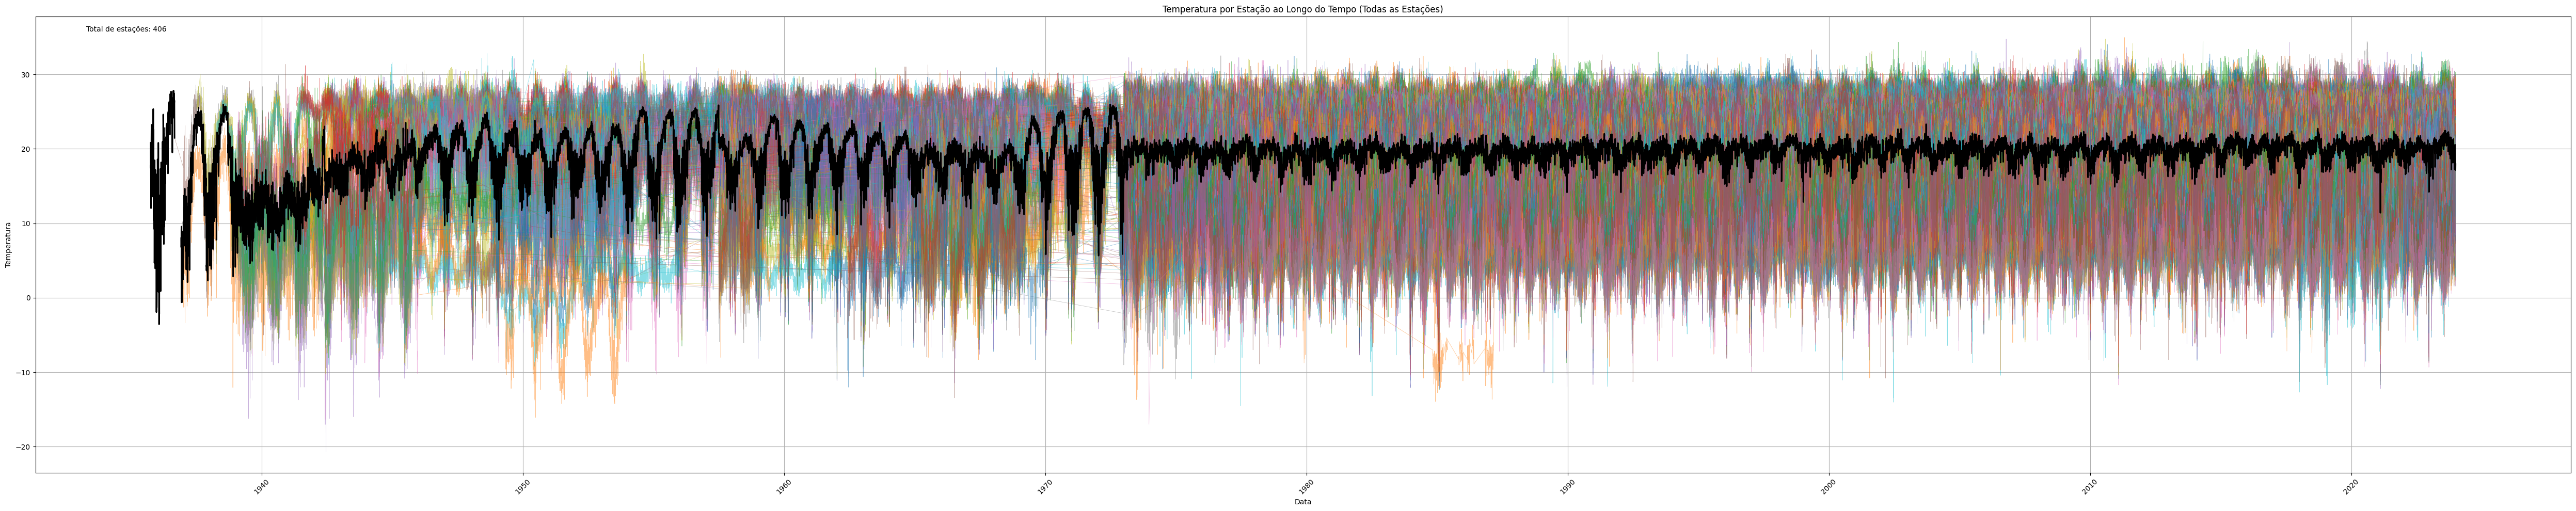

In [19]:
plot_all_station_temperatures(final_data, '1931-01-01', '2023-12-31')

In [20]:
def filter_high_temperatures(data: pd.DataFrame, threshold: float = 21.9) -> pd.DataFrame:
    """
    Filtra o DataFrame para manter apenas os registros com temperatura maior ou igual ao limiar especificado.
    
    :param data: DataFrame contendo os dados de temperatura
    :param threshold: Temperatura mínima para manter no DataFrame (padrão: 21.9)
    :return: Novo DataFrame contendo apenas os registros filtrados
    """
    high_temp_data = data[data['Temperatura'] >= threshold].copy()
    
    # Resetar o índice do novo DataFrame
    high_temp_data.reset_index(drop=True, inplace=True)
    
    print(f"Registros originais: {len(data)}")
    print(f"Registros com temperatura >= {threshold}°C: {len(high_temp_data)}")
    print(f"Porcentagem de registros mantidos: {len(high_temp_data) / len(data) * 100:.2f}%")
    
    return high_temp_data

In [21]:
high_temp_df = filter_high_temperatures(final_data)

# Para ver as primeiras linhas do novo DataFrame:
print(high_temp_df.head())

# Para ver um resumo estatístico do novo DataFrame:
print(high_temp_df.describe())

Registros originais: 13791008
Registros com temperatura >= 21.9°C: 3427924
Porcentagem de registros mantidos: 24.86%
        Data   Ano  Mes  Dia  Estacao  Latitude  Longitude  Elevacao  \
0 1935-10-12  1935   10   12       35    32.383     -86.35      52.1   
1 1935-10-13  1935   10   13       35    32.383     -86.35      52.1   
2 1935-10-15  1935   10   15       35    32.383     -86.35      52.1   
3 1935-10-16  1935   10   16       35    32.383     -86.35      52.1   
4 1935-10-20  1935   10   20       35    32.383     -86.35      52.1   

   Temperatura  
0        22.42  
1        23.24  
2        22.42  
3        22.28  
4        21.93  
                                Data           Ano           Mes  \
count                        3427924  3.427924e+06  3.427924e+06   
mean   1994-02-02 10:59:00.823425664  1.993583e+03  6.617200e+00   
min              1935-10-12 00:00:00  1.935000e+03  1.000000e+00   
25%              1980-09-08 00:00:00  1.980000e+03  4.000000e+00   
50%     

In [22]:
high_temp_df.head()

,Data,Ano,Mes,Dia,Estacao,Latitude,Longitude,Elevacao,Temperatura
0,1935-10-12,1935,10,12,35,32.383,-86.35,52.1,22.42
1,1935-10-13,1935,10,13,35,32.383,-86.35,52.1,23.24
2,1935-10-15,1935,10,15,35,32.383,-86.35,52.1,22.42
3,1935-10-16,1935,10,16,35,32.383,-86.35,52.1,22.28
4,1935-10-20,1935,10,20,35,32.383,-86.35,52.1,21.93


In [23]:
import folium
from folium.plugins import MarkerCluster

In [24]:
def plot_temperature_occurrences_map(data: pd.DataFrame, output_file: str = 'temperature_occurrences_map.html'):
    """
    Conta as ocorrências de altas temperaturas por estação e plota em um mapa interativo.
    
    :param data: DataFrame contendo os dados filtrados de alta temperatura
    :param output_file: Nome do arquivo HTML para salvar o mapa (padrão: 'temperature_occurrences_map.html')
    """
    # Contar ocorrências por estação
    occurrences = data['Estacao'].value_counts().reset_index()
    occurrences.columns = ['Estacao', 'Contagem']
    
    # Mesclar com as informações de latitude e longitude
    station_info = data[['Estacao', 'Latitude', 'Longitude']].drop_duplicates()
    occurrences = pd.merge(occurrences, station_info, on='Estacao')
    
    # Calcular o tamanho do marcador (normalizado entre 5 e 20)
    min_count = occurrences['Contagem'].min()
    max_count = occurrences['Contagem'].max()
    occurrences['MarkerSize'] = 5 + (occurrences['Contagem'] - min_count) / (max_count - min_count) * 15
    
    # Criar o mapa
    m = folium.Map(location=[occurrences['Latitude'].mean(), occurrences['Longitude'].mean()], 
                   zoom_start=4)
    
    # Adicionar marcadores ao mapa
    marker_cluster = MarkerCluster().add_to(m)
    
    for _, row in occurrences.iterrows():
        folium.CircleMarker(
            location=[row['Latitude'], row['Longitude']],
            radius=row['MarkerSize'],
            popup=f"Estação: {row['Estacao']}<br>Contagem: {row['Contagem']}",
            color='red',
            fill=True,
            fillColor='red'
        ).add_to(marker_cluster)
    
    # Salvar o mapa
    m.save(output_file)
    print(f"Mapa salvo como {output_file}")
    
    # Retornar o DataFrame de ocorrências para possível uso posterior
    return occurrences

In [25]:
occurrences_df = plot_temperature_occurrences_map(high_temp_df)

Mapa salvo como temperature_occurrences_map.html


In [27]:
occurrences_df.head()

,Estacao,Contagem,Latitude,Longitude,MarkerSize
0,227,24487,-1.379,-48.476,20.000000
1,165,24081,19.900,-75.150,19.751276
2,213,23241,10.890,-74.781,19.236676
3,174,22696,18.417,-66.000,18.902798
4,284,22395,-8.378,-74.574,18.718399


In [33]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt

def plot_temperature_occurrences_geopandas(data: pd.DataFrame):
    """
    Conta as ocorrências de altas temperaturas por estação e plota em um mapa usando GeoPandas.
    
    :param data: DataFrame contendo os dados filtrados de alta temperatura
    """
    # Contar ocorrências por estação
    occurrences = data['Estacao'].value_counts().reset_index()
    occurrences.columns = ['Estacao', 'Contagem']
    
    # Mesclar com as informações de latitude e longitude
    station_info = data[['Estacao', 'Latitude', 'Longitude']].drop_duplicates()
    occurrences = pd.merge(occurrences, station_info, on='Estacao')
    
    # Criar geometria de pontos
    geometry = [Point(xy) for xy in zip(occurrences['Longitude'], occurrences['Latitude'])]
    
    # Criar GeoDataFrame
    gdf = gpd.GeoDataFrame(occurrences, geometry=geometry, crs="EPSG:4326")
    
    # Calcular o tamanho dos marcadores
    max_count = gdf['Contagem'].max()
    gdf['marker_size'] = gdf['Contagem'] / max_count * 100
    
    # Criar o mapa
    fig, ax = plt.subplots(figsize=(15, 10))
    
    # Plotar o mapa-múndi como fundo
    world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
    world.plot(ax=ax, color='lightgrey', edgecolor='black')
    
    # Plotar os pontos
    gdf.plot(ax=ax, column='Contagem', cmap='YlOrRd', legend=True,
             legend_kwds={'label': 'Número de Ocorrências'},
             markersize=gdf['marker_size'])
    
    # Adicionar rótulos para as 10 estações com mais ocorrências
    top_10 = gdf.nlargest(10, 'Contagem')
    for idx, row in top_10.iterrows():
        ax.annotate(row['Estacao'], (row.geometry.x, row.geometry.y), xytext=(3, 3),
                    textcoords="offset points", fontsize=8, color='blue')
    
    plt.title('Ocorrências de Altas Temperaturas por Estação', fontsize=16)
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    
    plt.tight_layout()
    plt.show()
    
    return gdf

In [31]:
!pip install geopandas
!pip install geopandas mapclassify matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



   ---------------------------------------- 0.0/58.9 kB ? eta -:--:--
   ------ --------------------------------- 10.2/58.9 kB ? eta -:--:--
   ---------------------------------------- 58.9/58.9 kB 623.3 kB/s eta 0:00:00


C:\Users\paulo\AppData\Local\Temp\ipykernel_30000\4088685603.py:34: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


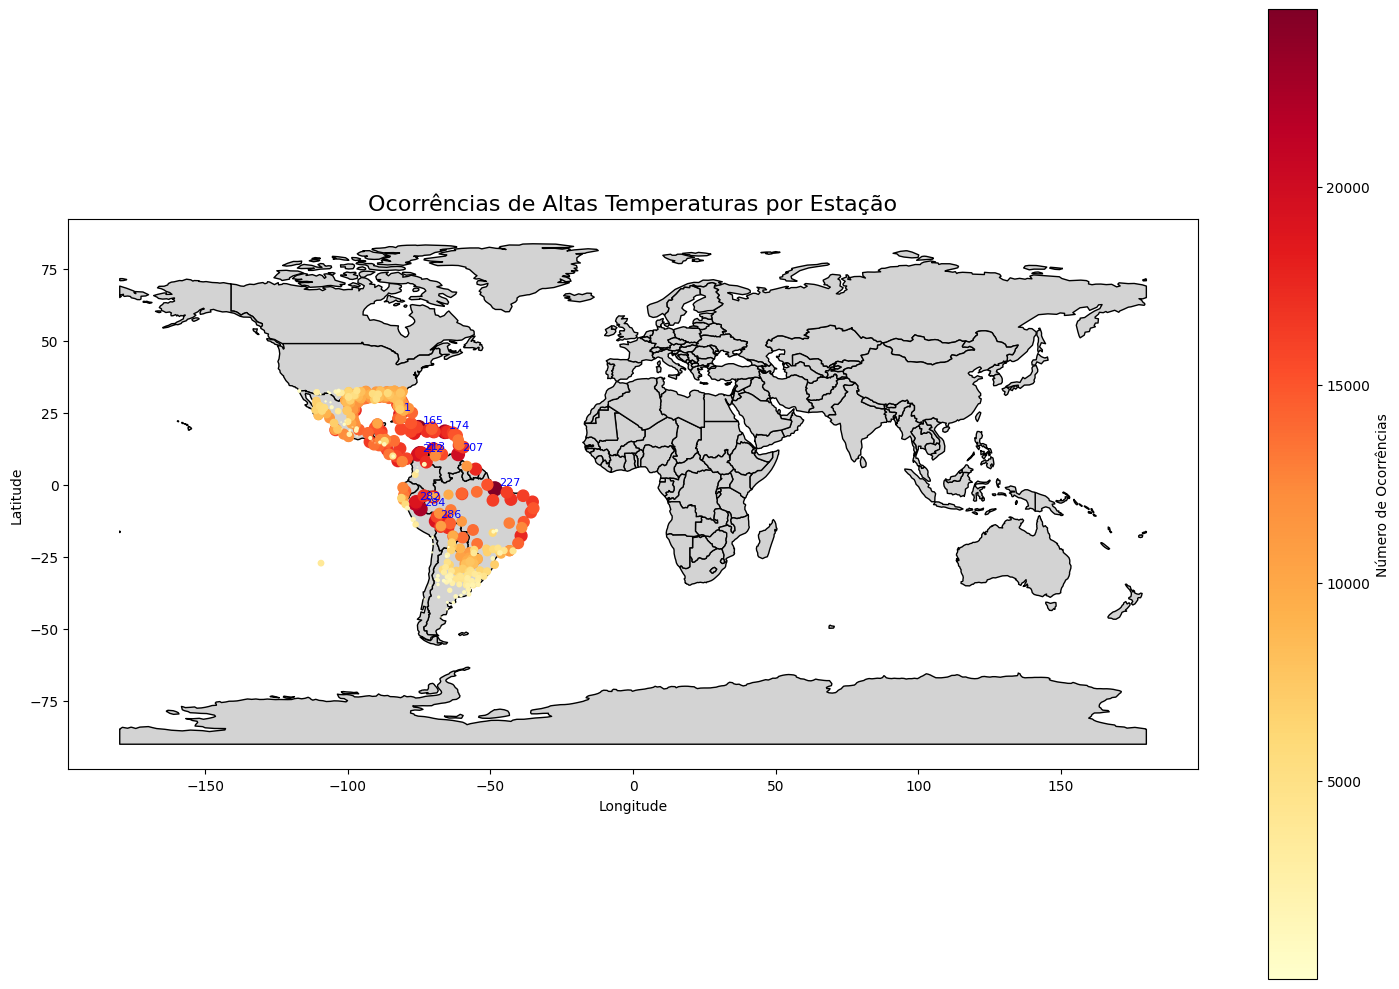

In [34]:
gdf = plot_temperature_occurrences_geopandas(high_temp_df)